# Adams Mini Challenge 2 
### Team = EMA
### Group Member: Edanur Kahvecioglu, Melike Merdan, Asena Ciloglu

# PACKAGE IMPORTING

In [39]:
import os
os.chdir("C:\Project")

In [40]:
import pandas as pd
import numpy as np
import keras
import re
import pickle

# Library beatifulsoup4 handles html
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Asena
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Asena
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asena C\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Asena
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# DATA IMPORTING & VISUALIZATION

Our aim for the assignment is to predict ratings of books based on the reviews by Amazon users. The data is from Amazon Book Reviews which includes 9 variables such as product id, product title, book reviews, review title etc. We have a large data set, containing 1099209 observations, each represents single book review of a user. In our analysis, we will be working on the reviews (review_body) and the ratings of each review (star_rating).

In our analysis, we used two models: RNN and logistic regression. The reason for that is that RNN, by its nature, promises better analysis for 'Natural Language Processing' as it helps us to analyze the interactions of embedding layers and to run recurrent neural network which it is better for capturing semantic meaning of the texts. Furthermore, logistic regression is easy to implement and does not require high computational power.



In [41]:
df = pd.read_csv("sample_data.csv")
df.shape

(109921, 10)

In [42]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
0,634662,634663,0880801484,The 5000 Year Leap,1,67,236,N,Light on facts.......,"Skousen has distorted some facts, and cherry-p..."
1,1049228,1049229,1888762144,Spanish Grammar for Independent Learners,5,13,15,Y,Great Book,An excellent tool. It covers verb conjugation...


For the sake of practicality, we took a random sample of 100.000 observations from the data to perform our coding steps. Since the whole data (MC2.csv) itself was too time consuming for processing.

In [43]:
# import random
# random.seed(123)
# df = data.sample(frac=0.1, replace=True)

# TRAIN / TEST SPLIT

In order to prevent overfitting due to processing test and train data together, in the very beginning we splitted data into test and train.

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review_body'], df['star_rating'], test_size=0.25, random_state=111)

To perform logistic regression in the next steps, we needed to save our train and test samples beforehands so that they will not get affected from the preprocessing steps for our NN model. 


In [45]:
y_test_log = y_test[:]
X_test_log = X_test[:]
y_train_log = y_train[:]
X_train_log = X_train[:]

In [46]:
train = pd.concat([X_train, y_train], axis=1)

In [47]:
# Due to technicality, we needed to substract one from our ratings.
#Later, we converted our rating results to arrays for neural network processes.
y_train = y_train - 1
y_test = y_test - 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

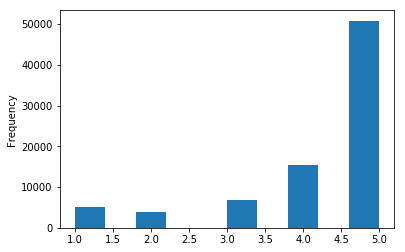

In [48]:
train["star_rating"].plot(kind='hist')

As can be seen from the histogram of star-ratings, 70% of the comments have 5-star-rating, which is likely to be imbalanced. Therefore, we used undersampling to eliminate the imbalance if possible.

 For undersampling, we found that star rating 2 has the lowest number of observations among all. Thus, we adjusted the number of other ratings with respect to 2. After we ran both of the models with undersampled data, our loss increased tremendously. We concluded that undersampling decreases the number of observations dramatically, which could carry valuable information as an input for our models. Eventually we did not use the undersampling method for our final models.


# DATA PROCESSING

In order to process the reviews, we applied common methods such as case equalization, part of speech tagging (wordnet_pos) according to word classes. Additionally, we performed BeautifulSoup to eliminate html texts if any, removed non-alphabetic characters and stopwords. Lastly, we lemmatized the words to create a simpler word set. We kept those word as tokens.

In [49]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [20]:
stop = stopwords.words("english")

X_train = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_test = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_sentences(df):
    reviews = []

    for sent in df:

        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text) 
       
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
  
        #lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        reviews.append(lemma_words)
        

    return(reviews)

Due to high computational cost, we saved our clean sentences with pickle and used the pickles in the rest of the analysis. The code below shows the original code we used to create the pickles.

In [ ]:
#train_sentences = clean_sentences(X_train)
#test_sentences = clean_sentences(X_test)

#filehandler = open('train.pkl',"wb")
#pickle.dump(train_sentences,filehandler)
#filehandler.close()

#filehandler_test = open('test.pkl',"wb")
#pickle.dump(test_sentences,filehandler_test)
#filehandler_test.close()

In [50]:
with open('train.pkl','rb') as filehandler:
    train_sentences = pickle.load(filehandler)

In [51]:
with open('test.pkl','rb') as filehandler_test:
    test_sentences = pickle.load(filehandler_test)

In order to obtain input matrices for neural network, the sentence sequences are needed to be filled with zeros until they reach the length of the longest sentence. (pad_sequences).In the beginning, we set our input matrix's length according to longest sentence in either train or test dataset, whichever is the longer. Due to computational time restrictions, we changed it to 200 (the average length is 162).

In [52]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(train_sentences)
seq = tokenizer_obj.texts_to_sequences(train_sentences)

In [53]:
tokenizer_obj.fit_on_texts(test_sentences)
seq_test = tokenizer_obj.texts_to_sequences(test_sentences)

In [54]:
longestsentence = max([len(s.split()) for s in X_train])
longestsentence_test = max([len(s.split()) for s in X_test])
longestone = max(longestsentence, longestsentence_test)
print(longestone)

5768


In [89]:
import statistics 
length_train = sum([len(s.split()) for s in X_train])/len([len(s.split()) for s in X_train]) #average length of sentences
length_train

162.46018922852983

In [90]:
length_test = sum([len(s.split()) for s in X_test])/len([len(s.split()) for s in X_test]) #average length of sentences
length_test

162.29489465448856

In [76]:
# for train
padded = pad_sequences(seq,200)
# for test
padded_test = pad_sequences(seq_test,200)

In [77]:
# We flipped the input matrices vertically since the zeros were inserted in the beginning of the sentence, 
# which could harm the semantic meaning of the words.

padded = np.flip(padded, axis=1) 
padded_test = np.flip(padded_test, axis=1)


# CREATING THE DICTIONARY

In order to build the dictionary for unique words (word_index) in our train set, we used tokenizer function from keras. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, we used 'Global Vectors for Word Representation' method as the embedding metric.



In [78]:
word_index = tokenizer_obj.word_index

In [79]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [80]:
emb=100
embedding_matrix = np.zeros((len(word_index) + 1, emb))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# MODEL

We used keras package for building the neural network model. For building the embedding layer of the NN,  we used the size of the vocabulary (len(word_index) +1 ) for input dimension and a reasonable number of a vector space (emb = 100) for output dimension.In the beginning, we determined the input length as the number of words from the longest sentence (longestone), while the weights will be implemented from the embedding matrix constructed above. After running our model, we changed our input length to 200, to prevent our computers to crash (the average length is 162).

In [81]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            emb,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=True)

We set the epoch size to a small number due to practical reasons, since each epoch lasted a lot of time. While building the NN, we added dropout layers to avoid overfitting and GRU to solve the vanishing gradient problem which comes with a standard recurrent NN. We used softmax as our activation function, which normalizes the output in a non-linear fashion so that the sum of output for all classes is equals to 1. Thereby, calculated probabilities are in the range of 0 to 1.Since it is a multiclass problem, we picked "categorical_crossentropy" as a loss function. 



As optimizer we used Adaptive Moment Estimation (Adam), which is an adaptive learning rate method and takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. Thus, it is also more stable and less volatile over the training epochs compared to other optimizer such as SGD. That’s why we only inserted learning rate and decay but no extra momentum. 

We chose a comparatively large learning rate of 0.1 and a smaller decay of 0.01 to optimize the learning over the small number of epochs. If we chose a smaller learning rate, larger number of epochs would be more suitable and stable. However, we would like to have the less time-consuming model since fitting our model is already very long process itself. 

In [82]:
#model without dropout
epochs = 3

model=Sequential()
model.add(embedding_layer) 
model.add(GRU(16))
model.add(Dense(5, activation="softmax")) 
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.adam(lr=0.1, decay=0.01), metrics=["accuracy"]) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          13796700  
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 13,802,401
Trainable params: 13,802,401
Non-trainable params: 0
_________________________________________________________________


Due to time constraint, we only ran 3 epochs at a time.

In [83]:
history = model.fit(padded , y_train , batch_size=64, epochs=epochs, validation_data = (padded_test, y_test), shuffle=True, verbose=1)

Train on 82440 samples, validate on 27481 samples
Epoch 1/3
82440/82440 [==============================] - 580s 7ms/step - loss: 1.1497 - acc: 0.6147 - val_loss: 1.1513 - val_acc: 0.6141
Epoch 2/3
82440/82440 [==============================] - 561s 7ms/step - loss: 1.1279 - acc: 0.6168 - val_loss: 1.1485 - val_acc: 0.6142
Epoch 3/3
82440/82440 [==============================] - 570s 7ms/step - loss: 1.1191 - acc: 0.6180 - val_loss: 1.1518 - val_acc: 0.6121


In [91]:
#model with dropout
epochs = 3

model=Sequential()
model.add(embedding_layer) 
model.add(Dropout(0.2)) 
model.add(GRU(16, dropout=0.1, recurrent_dropout=0.1))
model.add(Dropout(0.2)) 
model.add(Dense(5, activation="softmax")) 
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.adam(lr=0.1, decay=0.01), metrics=["accuracy"]) 
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          13796700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 13,802,401
Trainable params: 13,802,401
Non-trainable params: 0
_________________________________________________________________


In [92]:
history2 = model.fit(padded , y_train , batch_size=64, epochs=epochs, validation_data = (padded_test, y_test), shuffle=True, verbose=1)

Train on 82440 samples, validate on 27481 samples
Epoch 1/3
82440/82440 [==============================] - 616s 7ms/step - loss: 1.1542 - acc: 0.6153 - val_loss: 1.1519 - val_acc: 0.6152
Epoch 2/3
82440/82440 [==============================] - 610s 7ms/step - loss: 1.1290 - acc: 0.6165 - val_loss: 1.1509 - val_acc: 0.6149
Epoch 3/3
82440/82440 [==============================] - 612s 7ms/step - loss: 1.1142 - acc: 0.6172 - val_loss: 1.1582 - val_acc: 0.6148


Model with dropout gave us approxiamately loss of 1.13 and validation accuracy (on test data) of 0.615. 

# Logistic Regression Model

For our second model, we used Multiclass Logistic Regression.

In each observation, it assigns coefficients like we do in regular linear regression. After running for all observations, it simply calculates the averages of the input's (here word's) coefficients. In order to represent the input dataset as Bag of words, we will use CountVectorizer and call it’s transform method. It converts input texts into sparse matrix of features.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

CountVectorizer takes lowercase (default),  stopwords,  tokenizer as its inputs.
However, it is unable to process lemmatize function, so it had to be introduced additionally.
We introduced LemmaTokenizer, which performs tokenize and lemmatize at the same time.



In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, text):
        return [self.wnl.lemmatize(t) for t in word_tokenize(text)]

In [ ]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words= {'english'})

As running tokenizer, stop words, tokenizer and lemmatizer on such as big data, we saved the results by using pickle again.

In [ ]:
# vectorizer.fit(X_train_log)

# X_train_log = vectorizer.transform(X_train_log)
# X_test_log  = vectorizer.transform(X_test_log)

#  filehandler_log = open('X_train_log.pkl',"wb")
#  pickle.dump(X_train_log,filehandler_log)
#  filehandler_log.close()

#  filehandler_test_log = open('X_test_log.pkl',"wb")
#  pickle.dump(X_test_log,filehandler_test_log)
#  filehandler_test_log.close()

In [ ]:
with open('X_train_log.pkl','rb') as filehandler_log:
    X_train_log = pickle.load(filehandler_log)

In [ ]:
with open('X_test_log.pkl','rb') as filehandler_test_log:
    X_test_log = pickle.load(filehandler_test_log)

Using 'undersampling' for logistic regression led us have higher log_loss and lower accuracy than not using any method for sampling.
So we avoided using 'undersampling' method here and trained our model with train data (X_train_log here), analyzing first in terms of accuracy then log_loss.

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="lbfgs")
classifier.fit(X_train_log, y_train_log)

Applying our model on train dataset produced an accuracy score 74% while on test dataset it is 67%.
These accuracy rates are better than our RNN model.

In [ ]:
score_lr_train = classifier.score(X_train_log, y_train_log)

print("Accuracy:", score_lr_train)

Accuracy: 0.7498544395924308


In [ ]:
score_lr_test = classifier.score(X_test_log, y_test_log)

print("Accuracy:", score_lr_test)

Accuracy: 0.6771223754594083


Our main concern in this analysis is Log_loss value of our predictions. 
Log_loss value of train predictions is 0.67 while log_loss value of train predictions is 0.94. These log_loss values are better than our RNN model.

In [ ]:
y_pred = classifier.predict_proba(X_train_log)
from sklearn.metrics import log_loss
log_loss(y_train_log, y_pred)

0.6736884799113928

In [ ]:
y_pred_test = classifier.predict_proba(X_test_log)
from sklearn.metrics import log_loss
log_loss(y_test_log, y_pred_test)

0.9422729160279202

## PREDICTIONS

Our NN model by its nature, promises better analysis for 'Natural Language Processing' as it helps us to analyze the interactions of embedding layers and to run recurrent neural network which it is better for capturing semantic meaning of the texts. 
According to our results, we figured out that our Logistic Regression model is a better model than RNN model in terms of loss. 
In order to get predictions, we repeated every step of Logistic Regression on Known Data (MC2) and Unknown Data (MC2 Test). 



As we compared the results of our two models, we determined that logistic regression model performed better in terms of log loss function. That leaded us to set RNN model as benchmark for our analysis.

In [ ]:
known = pd.read_csv("sample_data.csv")

In [ ]:
X_known = known['review_body']
y_known = known['star_rating']

In [ ]:
unknown = pd.read_csv("MC2test.csv")

In [ ]:
X_unknown = unknown['review_body']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, text):
        return [self.wnl.lemmatize(t) for t in word_tokenize(text)]

In [ ]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words= {'english'})

In [ ]:
#vectorizer.fit(X_known)

#X_known = vectorizer.transform(X_known)
#X_unknown  = vectorizer.transform(X_unknown)

# filehandler_known = open('X_known.pkl',"wb")
# pickle.dump(X_known,filehandler_known)
# filehandler_known.close()

#filehandler_unknown = open('X_unknown.pkl',"wb")
#pickle.dump(X_unknown,filehandler_unknown)
#filehandler_unknown.close()

In [ ]:
with open('X_known.pkl','rb') as filehandler_known:
    X_known = pickle.load(filehandler_known)

In [ ]:
with open('X_unknown.pkl','rb') as filehandler_unknown:
    X_unknown = pickle.load(filehandler_unknown)

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="lbfgs")
classifier.fit(X_known, y_known)

In [ ]:
#predictions = model.predict_classes(X_test, verbose=0)
predictions = classifier.predict(X_unknown)

In [ ]:
unknown['product_id'] = unknown['product_id'].astype(str)

In [ ]:
def write_predictions(predictions, fname):
  pd.DataFrame({"product_id": unknown['product_id'], "star_rating": predictions}).to_csv(fname, index=False, header=True)

write_predictions(predictions, "MC2_EMA.csv")